In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath(".") 
if project_root not in sys.path:
    sys.path.append(project_root)
print(sys.path[-1])


/Users/dannyhuang/Developer/gflownet2/base


In [2]:
import numpy as np   
import argparse
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import argparse
import time
import datetime
import pickle

from disc_gflownet.utils.setting import set_seed, set_device, tf
from disc_gflownet.utils.plotting import plot_loss_curve
from disc_gflownet.agents.tbflownet_agent import TBFlowNetAgent
from disc_gflownet.agents.dbflownet_agent import DBFlowNetAgent
from disc_gflownet.envs.grid_env import GridEnv
from disc_gflownet.envs.set_env import SetEnv

from reward_func.evo_devo import oscillator_reward_func, somitogenesis_reward_func

# reward function 

In [3]:
# Define a custom reward function
def coord_reward_func(state):
    # reward1 = sum(1 for coord in state if coord == 5) + 0.001 # args.min_reward
    reward1 = sum(5 for coord in state if coord == 6) + 0.001 # args.min_reward
    reward2 = sum(10 for coord in state if coord == 8) + 0.001 # args.min_reward
    return reward1 + reward2


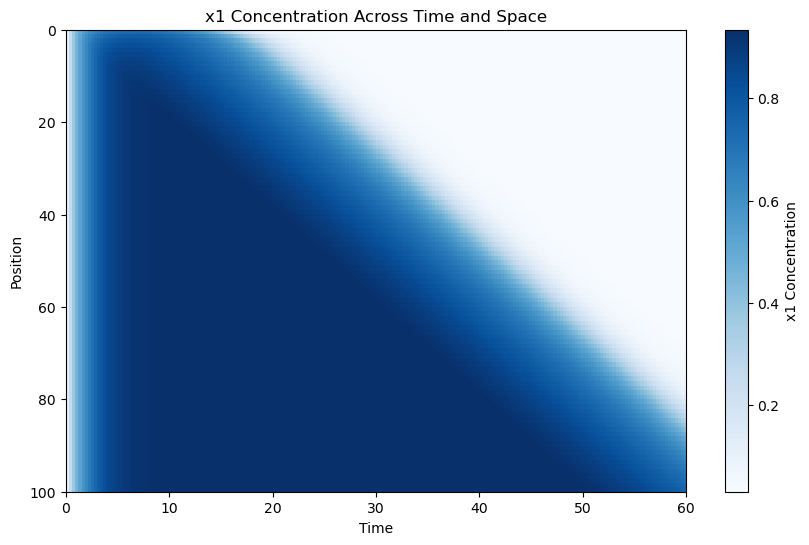

Reward for somitogenesis: 0.0


In [4]:

# test_weights = [-60, -150, 0, -109, 65, -66, -145, -41, 58] # -41(41), 58
test_weights = [44, -24, -26, 23, 55, 25, -51, 1, -3]
reward = somitogenesis_reward_func(test_weights, plot=True)
print(f"Reward for somitogenesis: {reward}")


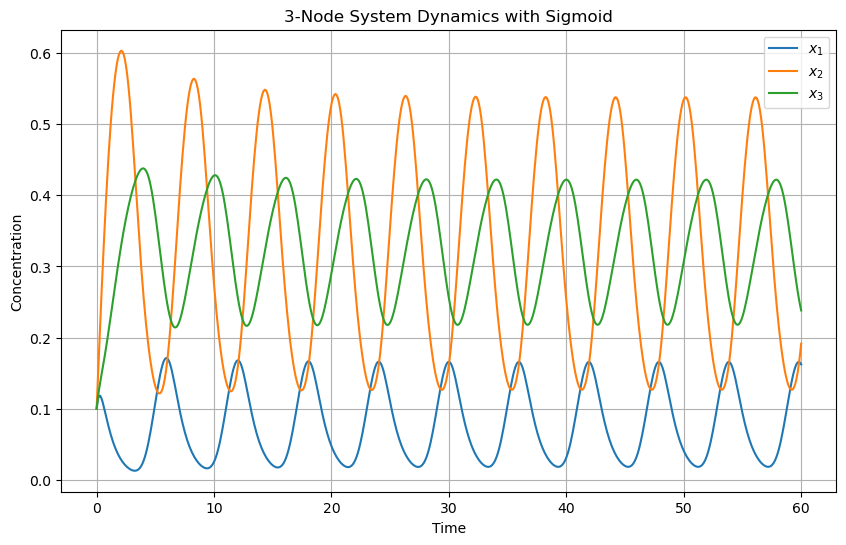

Reward for oscillator: 10


In [5]:
# test_weights = [-5, 2, 3, 1, 2, -1, 2, 1, -3] 
test_weights = [0, -10, 0, 4, 6, -10, -10, 0, 0]  # w12=-5, w22=..., w23=-10, w31=-10
reward = oscillator_reward_func(test_weights, plot=True)
print(f"Reward for oscillator: {reward}")

# Grid GFN 

In [6]:


def main(args):
    assert args.envsize == args.mbsize
    set_seed(args.seed)
    set_device(torch.device(args.device))
    
    envs = [GridEnv(args) for _ in range(args.envsize)]
    if args.method == 'tb':
        agent = TBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}, {'params':[agent.log_z], 'lr': args.tb_z_lr} ])
    elif args.method == 'db' or args.method == 'fldb':
        agent = DBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}])




    """Training Loop"""
    
    losses = [] 
    zs = []  # only for tb
    for i in tqdm(range(args.n_train_steps + 1), disable=not args.progress):
        experiences = agent.sample_batch_episodes(args.mbsize)
        if args.method == 'fldb':
            loss, z = agent.compute_batch_loss(experiences, use_fldb=True) 
        else:
            loss, z = agent.compute_batch_loss(experiences) 
            
        losses.append(loss.item())
        zs.append(z.item()) 

        loss.backward()
        opt.step()
        opt.zero_grad() 
        
        if i % args.log_freq == 0 and args.log_flag:
            log_training_loop(agent, i, log_filename)

    return losses, zs, agent



In [12]:

def log_arguments(args, log_filename):
    with open(log_filename, 'w') as f:
        f.write("Training Arguments:\n")
        f.write("-" * 50 + "\n")
        for arg, value in vars(args).items():
            f.write(f"{arg}: {value}\n")
        f.write("-" * 50 + "\n\n")
        
def log_training_loop(agent, step, log_filename):
    with open(log_filename, 'a') as f:
        print("\n", file=f)
        print("-" * 60, file=f)
        print(f"Step: {step}", file=f)
        print(f"Number of unique terminal states found: {len(agent.ep_last_state_counts)}", file=f)
        
        print("-" * 30, file=f)
        print("Top 10 by terminal rewards:", file=f)
        print("-" * 30, file=f)
        top_reward_states = sorted(
            agent.ep_last_state_ep_rewards.items(),
            key=lambda x: x[1][-1],  # Sort by last reward
            reverse=True
        )[:10]
        for state, rewards in top_reward_states:
            ep_rewards = [f"{r[0]:.3f}" for r in rewards]
            count = agent.ep_last_state_counts[state]
            print(f"State: {state}, Count: {count}, Full trajectory rewards: {ep_rewards}", file=f)
            print(f"Terminal reward: {rewards[-1][0]:.3f}\n", file=f)
            
        print("-" * 30, file=f)
        print("Top 10 by visit count:", file=f) 
        print("-" * 30, file=f)
        top_count_states = sorted(
            agent.ep_last_state_counts.items(),
            key=lambda x: x[1],  # Sort by count
            reverse=True
        )[:10]
        for state, count in top_count_states:
            rewards = agent.ep_last_state_ep_rewards[state]
            ep_rewards = [f"{r[0]:.3f}" for r in rewards]
            print(f"State: {state}, Count: {count}, Full trajectory rewards: {ep_rewards}", file=f)
            print(f"Terminal reward: {rewards[-1][0]:.3f}\n", file=f)
        print("\n", file=f)


def save_global_variables(variables, run_dir):
    for var_name, var_value in variables.items():
        with open(os.path.join(run_dir, f'{var_name}.pkl'), 'wb') as f:
            pickle.dump(var_value, f)




In [13]:

args = argparse.Namespace(
    device='cpu',
    progress=True,
    seed=0,
    n_train_steps=100,  # 2000
    log_freq=10,  # 1000
    log_flag=True,
    mbsize=16,
    # Model
    method='fldb', 
    learning_rate=1e-3,
    tb_lr=0.01,
    tb_z_lr=0.1,
    n_hid=256,
    n_layers=3,
    explore_ratio=0.2,  # 0.0625
    temp=1.,
    uni_rand_pb=1,
    # Env
    envsize=16,
    min_reward=0.01,
    custom_reward_fn=somitogenesis_reward_func,
    n_steps=72, # 8 * 9 = 72
    n_dims=9,  
    actions_per_dim=[1, 5, 25, -1, -5, -25], # if inhomogenous, need to be a closed symmetrical group.
    grid_bound=100,
    enable_time=True
)

# Create unique run directory with informative name
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"{args.method}_h{args.n_hid}_l{args.n_layers}_mr{args.min_reward}_ts{args.n_train_steps}_d{args.n_dims}_s{args.n_steps}_er{args.explore_ratio}_et{args.enable_time}" 
run_dir = os.path.join('runs', f'{timestamp}_{run_name}') 
os.makedirs(run_dir, exist_ok=True)

# Logging setup
if args.log_flag:
    log_filename = os.path.join(run_dir, 'training.log') 
    log_arguments(args, log_filename)


# Training
print(f"Number of threads in use by default: {torch.get_num_threads()}")
# torch.set_num_threads(1)
losses, zs, agent = main(args)


# Save global variables
if args.log_flag:
    save_global_variables(
        {"losses": losses, "zs": zs, "agent": agent},
        run_dir
    )



Number of threads in use by default: 5
Sequential(
  (0): Linear(in_features=1882, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=109, bias=True)
)
------------------------------------------
All available actions (action_names): 54
['(0): dim0 1', '(1): dim0 5', '(2): dim0 25', '(3): dim0 -1', '(4): dim0 -5', '(5): dim0 -25', '(6): dim1 1', '(7): dim1 5', '(8): dim1 25', '(9): dim1 -1', '(10): dim1 -5', '(11): dim1 -25', '(12): dim2 1', '(13): dim2 5', '(14): dim2 25', '(15): dim2 -1', '(16): dim2 -5', '(17): dim2 -25', '(18): dim3 1', '(19): dim3 5', '(20): dim3 25', '(21): dim3 -1', '(22): dim3 -5', '(23): dim3 -25', '(24): dim4 1', '(25): dim4 5', '(26): dim4 25', '(27): dim4 -1', '(28): dim4 -5', '(29): dim4 -25', '(30): dim5 

  3%|▎         | 3/101 [01:48<59:10, 36.23s/it]


KeyboardInterrupt: 

In [ ]:
title = "Loss and Z for the ({}) Model".format(args.method)
plot_loss_curve(losses, zs=zs, title=title)
print("The final Z (partition function) estimate is {:.2f}".format(zs[-1]))

# print(agent.state_counts)
# print(agent.state_returns)

In [ ]:
agent.env.print_actions()

In [ ]:
print("\n")
print("-"*10) 
# print("Step: ", i)
print("Number of unique states found: ", len(agent.ep_last_state_counts))
print("Top 12 states by visit count:")
top_states = sorted(agent.ep_last_state_counts.items(),
                    key=lambda x: x[1], # Sort by count
                    reverse=True)[:55]
for state, count in top_states:
    ep_rewards = [f"{r[0]:.3f}" for r in agent.ep_last_state_ep_rewards[state]]
    print(f"Count: {count}, State: {state}, Full trajectory rewards: {ep_rewards}")
print("\n")


# Testing

In [ ]:

"""Test case: Mixed positive/negative actions"""

args_mixed = argparse.Namespace(
    min_reward=0.001,
    custom_reward_fn=coord_reward_func,
    n_steps=5,
    n_dims=2,
    actions_per_dim=[1, -1, 2, -2],  # Mixed positive and negative actions
    grid_bound=5,
    enable_time=True
)
env_mixed = GridEnv(args_mixed)
env_mixed.print_actions()
env_mixed.reset()

mixed_test_state = (17, [-5, -5])
print("forward: ", env_mixed.get_forward_mask(mixed_test_state))
print("backward: ", env_mixed.get_backward_mask(mixed_test_state))
print("step: ", env_mixed._step)
print()  # Add blank line between iterations

